Name: Paniz Halvachi

Student Number: 98109729


In [1]:
#dependencies
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
#load the input image
def load_img(image_name):
    img = cv2.imread(image_name)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    plt.imshow(img)
    img = np.asarray(img, dtype="int32")
    image_pixels = np.reshape(img, (-1, img.shape[2]))
    #I changed img_matrix
    return image_pixels

array([[ 60,  50, 175],
       [ 59,  49, 174],
       [ 55,  45, 170],
       ...,
       [ 24,  20, 130],
       [ 14,  10, 120],
       [  7,   3, 113]])

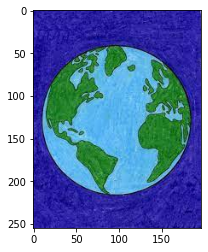

In [3]:
#write the name of your image here
image_name = 'earth.jfif'
image_pixels = load_img(image_name)
image_pixels

In [4]:
#determine number of desired classes here:
number_of_classes = 3

In [5]:
#Color each segment of your image. Add your desired colors in RGB format here, as an example:
#here number of desired classes for image segmentation is 3
colors = [
        (255, 0, 0),    # red
        (0, 255, 0),    # green
        (0, 0, 255),    # blue
        # ...
    ]

In [6]:
def find_distance(x, y):
    k = y.shape[0]
    data_size = x.shape[0]
    x_norm = np.repeat(np.expand_dims(np.linalg.norm(x, axis = 1) ** 2, 1), k, axis = 1)
    y_norm = np.repeat(np.expand_dims(np.linalg.norm(y, axis = 1) ** 2, 0), data_size, axis = 0)
    x_y_inner = np.matmul(x, y.T)
    result = x_norm + y_norm - 2 * x_y_inner
    return result

class Kmeans:
    def __init__(self, x, k, max_iters = 1000):
        self.x = x
        self.data_size , self.feature_size = np.shape(x)
        self.k = k
        self.max_iters = max_iters
        self.centers = np.zeros((k, x.shape[1]))
        self.predictions = np.zeros(self.data_size)

    def predict(self):
        mean = np.mean(self.x, axis = 0)
        std = np.std(self.x, axis = 0)
        centers = np.random.randn(self.k, self.feature_size) * mean + std
        for i in range(self.max_iters):
            data_center_dists = find_distance(self.x, self.centers)
            self.predictions = data_center_dists.argmin(axis = 1)
            prev_centers = np.copy(self.centers)
            for j in range(self.k):
                cluster_j = self.x[self.predictions == j] 
                if len(cluster_j) > 0:
                    self.centers[j] = cluster_j.mean(axis = 0)
            if (prev_centers == self.centers).all():
                return

clusters:  [0 1 2]
number of points:  [13490 10400 26345]


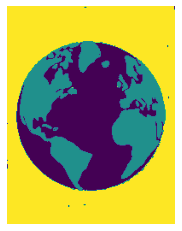

In [7]:
#clustering result with k=3 using  k_means
datas = image_pixels
model = Kmeans(datas, number_of_classes)
model.predict()
img = cv2.imread(image_name)
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
img = np.asarray(img, dtype="int32")
image_clustered = model.predictions.reshape((img.shape[0], img.shape[1]))
print('clusters: ', np.unique(image_clustered, return_counts = True)[0])
print('number of points: ', np.unique(image_clustered, return_counts = True)[1])
plt.figure()
plt.imshow(image_clustered)
plt.axis('off')
plt.show();

In [8]:
#for better results, do the initializations with Kmeans 
def kmeans(number_of_classes, image_pixels):
    #your code here
    datas = image_pixels
    num_samples, num_features = np.shape(datas)
    covariances = []
    pi = []
    for i in range(number_of_classes):
        summed = 0
        clusterData = datas[model.predictions == i]
        cluster_center = model.centers[i]
        for clusterMember in clusterData:
            summed += np.dot((clusterMember - cluster_center),(clusterMember - cluster_center))
        covariance = np.eye(3)*(summed / len(clusterData))
        covariances.append(covariance)
        pi.append(len(clusterData/num_samples))
    return model.centers, pi, covariances         

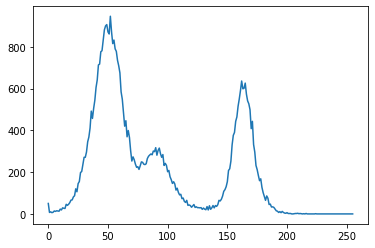

In [9]:
#for better results, observe the image histogram
def get_img_histogram(image_pixels):
    #your code here
    img = cv2.imread(image_name,0)
    # find frequency of pixels in range 0-255
    histr = cv2.calcHist([img],[0],None,[256],[0,256])
  
    # show the plotting graph of an image
    plt.plot(histr)
    plt.show()
    pass
get_img_histogram(datas)

In [10]:
class GMM:
    
    def __init__(self, number_of_classes, initial_mu_s, initial_sigma_s, initial_priors):
        #I changed it
        self.ncomp = number_of_classes
        self.mu_s = np.asarray(initial_mu_s)
        self.sigma_s = np.asarray(initial_sigma_s)
        self.priors = np.asarray(initial_priors)
    
    def get_pdf_multivariate_gaussian_distribution(self, datas , num_samples, num_features):
        #computing x - mu 
        x_mu = np.reshape(datas, (num_samples, 1, num_features) ) - np.reshape(self.mu_s, (1, self.ncomp, num_features) )
        #computing inverse of sigma 
        sigma_inverse = np.linalg.inv(self.sigma_s)

        #computing (x - mu)^T sigma^-1 (x - mu)
        #using einsum to calculate transpose and dot for multi-dimensional arrays 
        # nki,kij -> nkj means that here we multiply transpose of x - mu with sigma_inverse ---> (x - mu)^T sigma^-1
        x_mu_sigma_inverse =  np.einsum("nki,kij->nkj", x_mu, sigma_inverse)
        # nkj,nkj -> nk means that here we multiply (x - mu) and np.einsum("nki,kij->nkj",  x_mu, sigma_inverse) 
        exponent = np.einsum("nkj,nkj->nk",x_mu_sigma_inverse, x_mu)

        #N (xn|µk, Σk) = exp(-0.5*(x - mu)^T . sigma^-1 . (x - mu)) * (2pi)^(-n/2) * (sqrt(det(sigma))^-1 where n is nu,ber of features
        N = np.exp(-0.5*exponent) / (((2*np.pi)**(num_features/2))*np.sqrt(np.linalg.det(self.sigma_s)))
        return N


    # Write E step here
    def inference(self, datas):
        #your code here
        #get number of samples and features
        num_samples, num_features = np.shape(datas)
        # N(x|mu , sigma)
        N_gaussian = self.get_pdf_multivariate_gaussian_distribution(datas, num_samples , num_features)
        # π(x|µ, Σ)
        numerator = self.priors * N_gaussian
        # sum of π(x|µ, Σ)
        sum = np.sum(numerator , axis =1)
        sum = np.reshape(sum, (num_samples, 1))
        #gamma = nprmalized π(x|µ, Σ)
        Gamma = numerator / sum
        return Gamma
        
        
    # Write M step here
    def update(self, datas, gammas): #beliefs):
        #your code here
        #get number of samples and features
        num_samples, num_features = np.shape(datas)
        #computing x - mu
        x_mu = np.reshape(datas, (num_samples, 1, num_features) ) - np.reshape(self.mu_s, (1, self.ncomp, num_features) )
        #Nk = sum of gamma_ik over samples
        Nk = np.sum(gammas, axis=0)
        #πk = sum of gamma_ik over samples / N = Nk/N
        self.priors = Nk/num_samples
        #mu_k = sum of (gamma _ik * x_i) over all samples / Nk
        self.mu_s = gammas.T @ datas / np.reshape(Nk, (self.ncomp, 1))
        #sigma_k = sum of (gamma _ik * (x-mu)*(x-mu)^T) over all samples / Nk
        #computing x - mu
        x_mu = np.reshape(datas, (num_samples, 1, num_features) ) - np.reshape(self.mu_s, (1, self.ncomp, num_features) )
        # gamma _ik * (x-mu)
        temp = np.einsum("nk,nki->nki", gammas, x_mu)
        # temp * (x-mu)^T
        temp = np.einsum("nki,nkj->kij", temp, x_mu)
        self.sigma_s = temp / np.reshape(Nk, (self.ncomp, 1, 1)) 
        pass
            
    def predict_probability(self, datas):
        Gamma = self.inference(datas)
        return Gamma
    
    def predict(self, datas):
        predictions = np.argmax(self.predict_probability(datas), axis=1)
        return predictions    
    
    

clusters:  [0 1 2]
number of points:  [13422 10638 26175]


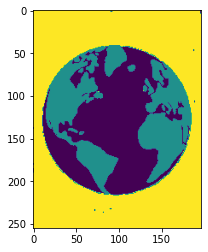

In [11]:
#write your main function here
#use of kmeans or histogram of the image for better initialization is optinal
#call the GMM functions here

# I use K_means for initialization
initial_mu , initial_pi, initial_sigma = kmeans(number_of_classes , datas)
gmm = GMM(number_of_classes, initial_mu, initial_sigma, initial_pi)
temp=gmm.predict(datas)

clustered_img = temp.reshape((img.shape[0], img.shape[1]))
print('clusters: ', np.unique(clustered_img, return_counts = True)[0])
print('number of points: ', np.unique(clustered_img, return_counts = True)[1])
plt.figure()
plt.imshow(clustered_img)

clustered_img = clustered_img.astype("uint8") * 255

In [12]:
#show and save your results
#let the final image variable be clustered_img
def save_img(clustered_img):
    plt.imshow(clustered_img)
    final_img = cv2.cvtColor(clustered_img,cv2.COLOR_RGB2BGR)
    cv2.imwrite("result.jpg", final_img)

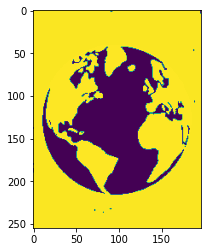

In [13]:
save_img(clustered_img)